In [1]:
from src.test_non_local_switching_non_stationary_model import load_data

is_ripple, spikes, position, speed, env, time = load_data(work_computer=False)


In [2]:
from src.test_non_local_switching_non_stationary_model import (
    setup_nonlocal_switching_model,
)

(
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    continuous_state_transitions,
    state_ind,
    no_spike_rates,
    is_training,
    state_names,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    speed,
    env,
    no_spike_rate_threshold=0.01,
    no_spike_rate=1e-3,
    is_stationary_discrete_transition=True,
)


In [3]:
import numpy as np
import scipy.stats
from src.test_non_local_switching_non_stationary_model import fit_poisson_regression, tqdm, EPS


n_time = spikes.shape[0]
n_states = discrete_state_transitions.shape[-1]
n_state_bins = continuous_state_transitions.shape[0]

causal_state_probabilities = np.zeros((n_time, n_states))
acausal_state_probabilities = np.zeros((n_time, n_states))
predictive_state_probabilities = np.zeros((n_time, n_states))

coefficients_iter = []
local_rates_iter = []
non_local_rates_iter = []
is_training_iter = []
acausal_posterior_iter = []

marginal_log_likelihoods = []
n_iter = 0
converged = False

log_likelihood = np.zeros((n_time, n_state_bins))
log_likelihood[:, state_ind == 1] = np.sum(
    scipy.stats.poisson.logpmf(spikes, no_spike_rates), axis=-1, keepdims=True
)


coefficients = []
local_rates = []
non_local_rates = []

for neuron_spikes in tqdm(spikes.T):
    coef = fit_poisson_regression(
        emission_design_matrix,
        is_training.astype(float),
        neuron_spikes,
        l2_penalty=1e-5,
    )
    coefficients.append(coef)

    local_rate = np.exp(emission_design_matrix @ coef)
    local_rate = np.clip(local_rate, a_min=EPS, a_max=None)
    local_rates.append(local_rate)
    log_likelihood[:, state_ind == 0] += scipy.stats.poisson.logpmf(
        neuron_spikes, local_rate
    )[:, np.newaxis]

    non_local_rate = np.exp(emission_predict_matrix @ coef)
    non_local_rate = np.clip(non_local_rate, a_min=EPS, a_max=None)
    non_local_rates.append(non_local_rate)

    log_likelihood[:, state_ind == 2] += scipy.stats.poisson.logpmf(
        neuron_spikes[:, np.newaxis], non_local_rate[np.newaxis]
    )

coefficients = np.stack(coefficients, axis=1)
local_rates = np.stack(local_rates, axis=1)
non_local_rates = np.stack(non_local_rates, axis=1)


  0%|          | 0/104 [00:00<?, ?it/s]

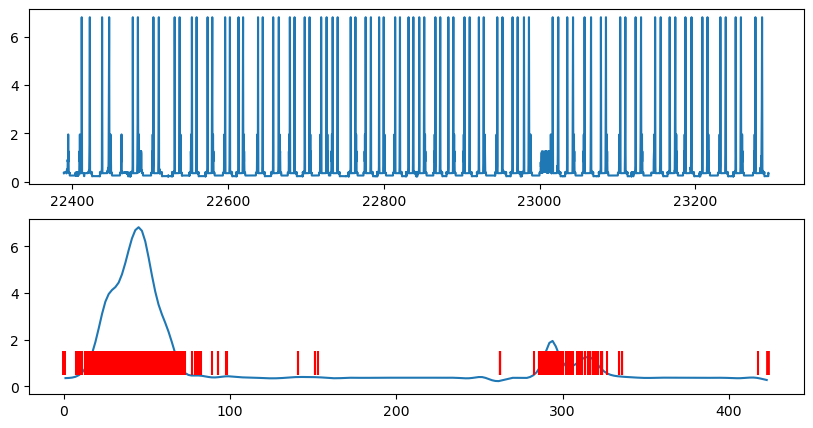

In [4]:
import matplotlib.pyplot as plt

neuron_ind = 30

fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(time, local_rates[:, neuron_ind] * 500.0)
axes[1].plot(env.place_bin_centers_, non_local_rates[:, neuron_ind] * 500.0)

axes[1].eventplot(position[spikes[:, neuron_ind].astype(bool)], color="red")

1.0

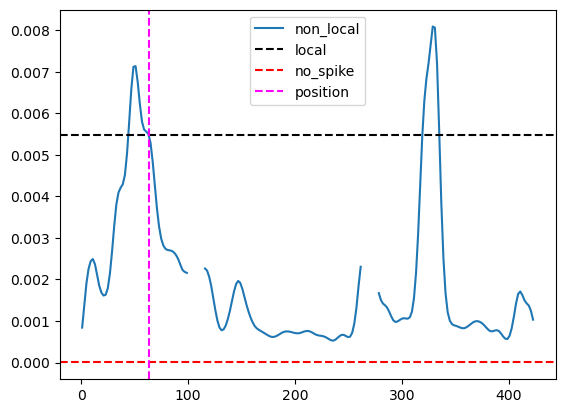

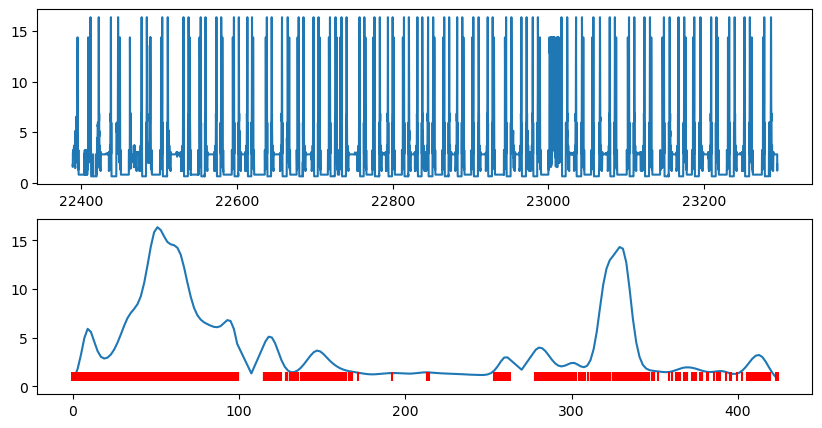

In [116]:
time_ind = 193_673
mask = env.is_track_interior_.astype(float)
mask[~env.is_track_interior_] = np.nan

plt.plot(env.place_bin_centers_, np.exp(log_likelihood[time_ind, state_ind == 2]) * mask, label="non_local")
plt.axhline(np.exp(log_likelihood[time_ind, state_ind == 0]), color="black", linestyle="--", label="local")
plt.axhline(np.exp(log_likelihood[time_ind, state_ind == 1]), color="red", linestyle="--", label="no_spike")

plt.axvline(position[time_ind], color="magenta", linestyle="--", label="position")

plt.legend()
neuron_inds = np.nonzero(spikes[time_ind])[0]

for neuron_ind in neuron_inds:
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))
    axes[0].plot(time, local_rates[:, neuron_ind] * 500.0)
    axes[1].plot(env.place_bin_centers_, non_local_rates[:, neuron_ind] * 500.0)

    axes[1].eventplot(position[spikes[:, neuron_ind].astype(bool)], color="red")
    
    
spikes[time_ind].sum()

In [ ]:
neuron_spikes[:, np.newaxis].shape

In [ ]:
non_local_rate[np.newaxis].shape

In [ ]:
env.is_track_interior

In [53]:
log_likelihood[:, state_ind == 2][:, ~env.is_track_interior_] = np.nan

In [ ]:
plt.plot(env.place_bin_centers_, )

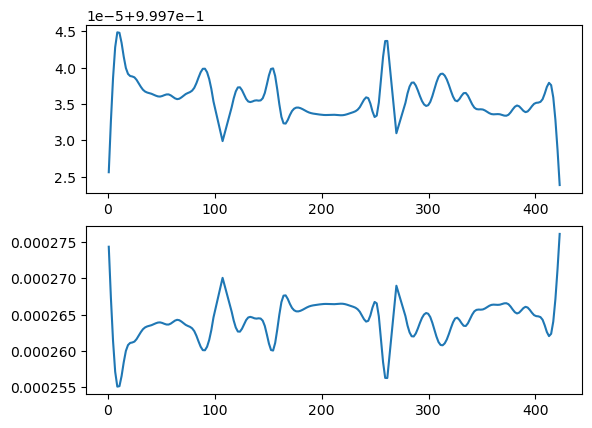

In [96]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(env.place_bin_centers_, np.exp(scipy.stats.poisson.logpmf(0, non_local_rates[:, -1])))
axes[1].plot(env.place_bin_centers_, np.exp(scipy.stats.poisson.logpmf(1, non_local_rates[:, -1])))

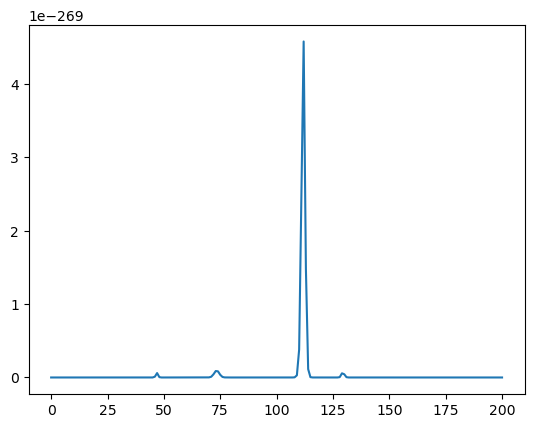

In [102]:
plt.plot(np.exp(np.sum(scipy.stats.poisson.logpmf(1, non_local_rates), axis=1)))

In [104]:
np.exp(np.sum(scipy.stats.poisson.logpmf(1, non_local_rates), axis=1))

array([5.44996632e-297, 4.31266134e-290, 3.83549493e-284, 1.02379181e-279,
       2.37678399e-277, 5.99102125e-277, 1.19770725e-277, 1.58010076e-278,
       1.16828021e-278, 1.04984654e-277, 3.10941088e-276, 6.93916044e-275,
       2.74106053e-274, 1.06700860e-274, 1.07595368e-275, 8.75427212e-277,
       1.80542303e-277, 1.79605714e-277, 5.20064341e-277, 2.25689358e-276,
       7.59522070e-276, 1.27408835e-275, 1.24183938e-275, 9.07934530e-276,
       6.42678719e-276, 5.34288523e-276, 5.09097975e-276, 5.18012612e-276,
       5.26267919e-276, 5.07123094e-276, 4.65411227e-276, 4.14011792e-276,
       3.63348614e-276, 3.18041701e-276, 2.68608319e-276, 2.08717025e-276,
       1.42491603e-276, 8.31867303e-277, 4.59234231e-277, 2.80130551e-277,
       2.20698254e-277, 2.63315121e-277, 5.82063478e-277, 2.99646680e-276,
       4.53549984e-275, 2.27267842e-273, 1.08723496e-271, 5.98156350e-271,
       4.55338863e-272, 6.73856615e-276, 7.10766325e-294, 8.69853738e-277,
       6.93701837e-275, 3

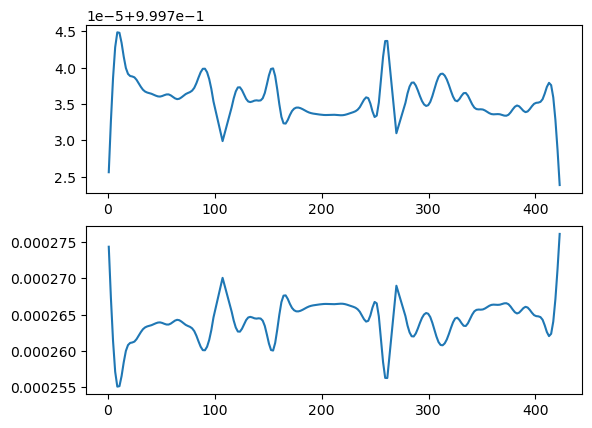

In [95]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(env.place_bin_centers_, np.exp(scipy.stats.poisson.logpmf(0, non_local_rate)))
axes[1].plot(env.place_bin_centers_, np.exp(scipy.stats.poisson.logpmf(1, non_local_rate)))

In [85]:
env.place_bin_centers_.shape

(201, 1)

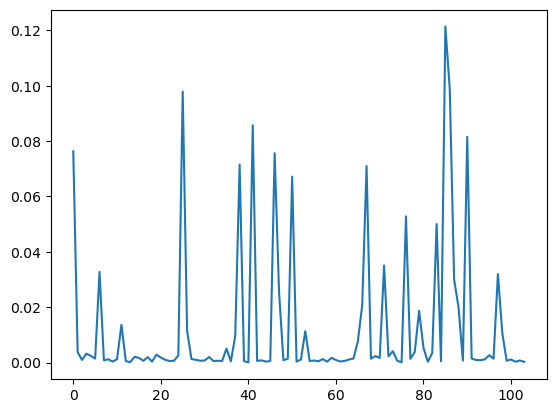

In [80]:
plt.plot(non_local_rates[100])

In [79]:
non_local_rates[100]

array([7.62882802e-02, 3.76745369e-03, 9.45862981e-04, 3.21226387e-03,
       2.39017376e-03, 1.45246199e-03, 3.27579089e-02, 8.06229771e-04,
       1.17141533e-03, 3.30401336e-04, 1.20253552e-03, 1.36295078e-02,
       5.26880559e-04, 1.12122984e-04, 2.05039287e-03, 1.68484067e-03,
       6.16090715e-04, 1.95133653e-03, 3.30492087e-04, 2.87433588e-03,
       1.77265211e-03, 9.85889527e-04, 5.55136617e-04, 6.25133599e-04,
       2.55954768e-03, 9.78773506e-02, 1.14781517e-02, 1.26217914e-03,
       9.90900924e-04, 6.48545579e-04, 7.38522045e-04, 1.99465937e-03,
       5.73622233e-04, 6.38259145e-04, 5.34758181e-04, 5.05467699e-03,
       3.79874480e-04, 9.57108629e-03, 7.15477956e-02, 5.02640678e-04,
       2.03451441e-05, 8.56872061e-02, 5.53297619e-04, 7.96162528e-04,
       3.42229571e-04, 5.26761321e-04, 7.56059258e-02, 2.57157048e-02,
       8.63947889e-04, 1.36499050e-03, 6.71682461e-02, 3.33604865e-04,
       1.07563401e-03, 1.13260875e-02, 5.50276931e-04, 7.24927378e-04,
      

In [125]:
np.exp(-np.inf)

0.0

In [130]:
np.exp(np.nextafter(-np.inf, 0.0, dtype=np.float32))

False

In [128]:
np.exp(-np.inf)

0.0

In [131]:
np.nextafter(-np.inf, 0, dtype=np.float32)

-3.4028235e+38

In [134]:
np.clip(-np.inf, a_min=np.nextafter(-np.inf, 0, dtype=np.float32), a_max=1.0)

-3.4028234663852886e+38

In [139]:
np.nextafter(0.0, 1, dtype=np.float32) * 1.1

1.541428310757299e-45

In [146]:
np.nextafter(0.0, 1.0, dtype=np.float32)

1e-45

In [147]:
np.save("coefficients.npy", coefficients)
np.save("local_rates.npy", local_rates)
np.save("non_local_rates.npy", non_local_rates)
np.save("log_likelihood.npy", log_likelihood)

In [150]:
np.load("log_likelihood.npy")

array([[-1.05314249e+01, -2.62449348e+01, -1.16664645e+01, ...,
        -1.19442297e+01, -1.11813016e+01, -1.03483950e+01],
       [-1.37947990e+00, -2.08000000e-04, -7.69526826e-01, ...,
        -1.04859112e+00, -8.12947189e-01, -6.28227685e-01],
       [-9.94536011e+00, -2.62449348e+01, -8.95921463e+00, ...,
        -7.77742045e+00, -8.09692792e+00, -8.58198868e+00],
       ...,
       [-6.38650585e+00, -2.62449348e+01, -7.18463253e+00, ...,
        -6.03395598e+00, -6.43263662e+00, -6.98465429e+00],
       [-1.37261947e+00, -2.08000000e-04, -7.69526826e-01, ...,
        -1.04859112e+00, -8.12947189e-01, -6.28227685e-01],
       [-1.37261947e+00, -2.08000000e-04, -7.69526826e-01, ...,
        -1.04859112e+00, -8.12947189e-01, -6.28227685e-01]])

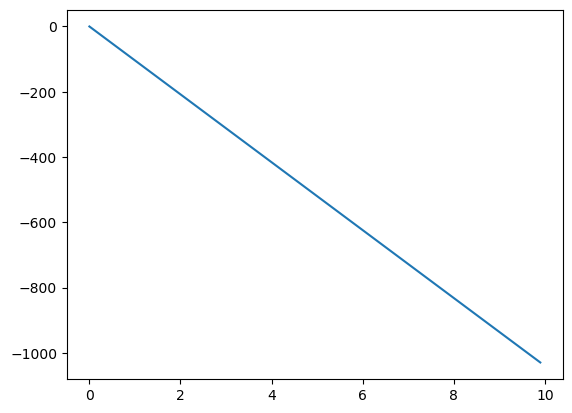

In [55]:
import scipy.stats
import matplotlib.pyplot as plt

x = np.arange(0, 10, 0.1)

plt.plot(x, scipy.stats.poisson.logpmf(0, x) * non_local_rates.shape[1])

In [58]:
scipy.stats.poisson.logpmf(0, 0.3)

-0.3

In [59]:
import numpy as np

non_local_rates = np.load("non_local_rates.npy")

np.sum(scipy.stats.poisson.logpmf(1, non_local_rates), axis=1)

array([-682.17216319, -666.28812177, -652.58986793, -642.39772775,
       -636.95032245, -636.02580887, -637.63566166, -639.66116723,
       -639.96312309, -637.76742676, -634.37905238, -631.27371978,
       -629.89997058, -630.84345644, -633.13769316, -635.64652894,
       -637.22527583, -637.23047698, -636.16728841, -634.69949632,
       -633.48596647, -632.96866967, -632.99430692, -633.30748358,
       -633.65301091, -633.83771985, -633.88601537, -633.86865626,
       -633.85284542, -633.88990209, -633.97573448, -634.09276139,
       -634.22329311, -634.35647334, -634.5254016 , -634.77767647,
       -635.15937278, -635.69756801, -636.29168056, -636.7859852 ,
       -637.02444454, -636.84788945, -636.05466144, -634.41605181,
       -631.69896528, -627.78477133, -623.91692246, -622.21187821,
       -624.78727358, -633.6056385 , -674.99884381, -635.65291587,
       -631.27402852, -629.71840273, -630.58066583, -633.42072202,
       -637.40720847, -641.49191514, -644.60987103, -645.73874